<a href="https://colab.research.google.com/github/tomMEM/Weather_data/blob/main/Weather_data_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/My Drive

In [ ]:
%cd Weather

/content/drive/My Drive/Weather


In [18]:
! ls

Weather_data_scraping.ipynb


### 1 Install Meteostat 
 * WEB:https://meteostat.net/en/place/CA-QVT9?t=2021-09-13/2021-09-19
 * Script sample: https://pypi.org/project/meteostat/

In [ ]:
! pip install meteostat 

In [ ]:
# might be not required
import sys
!{sys.executable} -m pip install --upgrade pandas==1.1.0 --no-cache-dir
!{sys.executable} -m pip install --upgrade urllib3==1.25.8 --no-cache-dir
!{sys.executable} -m pip install pandas-datareader --no-cache-dir

In [ ]:
# Might be not required
from pandas_datareader import data as pdr
import pandas as pd
from pandas import *
from pandas import ExcelWriter
import pandas as pd
import datetime
import time

import os.path
from os import path
import csv

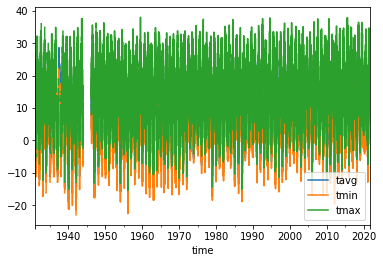

In [34]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

# Set time period 
start = datetime(1930, 9, 15)
end = datetime(2021, 9, 15)
location_name='Berlin'

# Create Point for Vancouver, BC
#location = Point(49.2497, -123.1193, 70)

# TB: Create Point for Berlin, Germany
location = Point(52.5244, 13.4105, 70)

# Get daily data for 2018
data = Daily(location, start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()


In [35]:
data.tail()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2021-09-11,18.5,16.1,22.2,2.0,NaN,239.2,10.0,24.1,1015.1,204.0
2021-09-12,17.4,14.4,20.9,0.0,NaN,261.1,10.9,25.9,1016.3,99.0
2021-09-13,15.8,13.1,18.7,0.0,NaN,294.5,10.5,27.8,1017.8,NaN
2021-09-14,15.9,11.1,21.3,0.0,NaN,113.6,8.2,24.1,1018.4,NaN
2021-09-15,17.8,13.4,22.9,4.6,NaN,143.4,12.1,27.8,1013.2,NaN


In [36]:
data.to_csv(location_name+'.csv')